Dieses Notebook enthält die Daten aus detected_syringes und dected_syringes with bubbles

In [ ]:
import os
import glob
import cv2 as cv
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from collections import Counter


Geladene 'ok'-Bilder: 648
Geladene 'defect'-Bilder: 588
Verwendete Klassen im Datensatz: (array(['defect', 'ok'], dtype='<U6'), array([588, 648], dtype=int64))

--- Classification Report (Unweighted) ---
              precision    recall  f1-score   support

      defect       1.00      1.00      1.00       118
          ok       1.00      1.00      1.00       130

    accuracy                           1.00       248
   macro avg       1.00      1.00      1.00       248
weighted avg       1.00      1.00      1.00       248



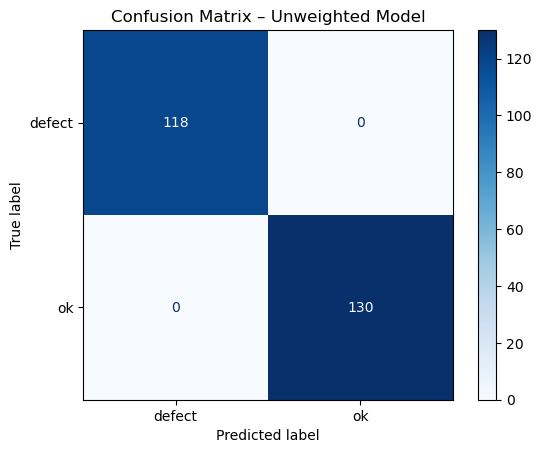


--- Classification Report (Weighted) ---
              precision    recall  f1-score   support

      defect       1.00      1.00      1.00       118
          ok       1.00      1.00      1.00       130

    accuracy                           1.00       248
   macro avg       1.00      1.00      1.00       248
weighted avg       1.00      1.00      1.00       248



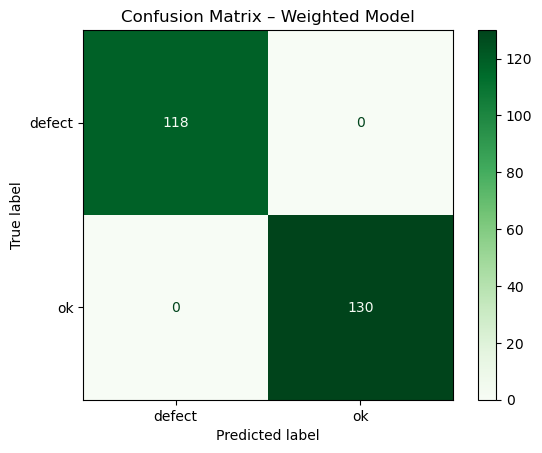


Model saved as syringe_model_roi_weighted.pkl


In [ ]:


# --- Paths ---
ok_folder = "detected_syringes"
defect_folder = "detected_syringes_with_bubbles"

# --- Feature extraction ---
def extract_features(image_path):
    img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv.resize(img, (64, 64))
    blur = cv.GaussianBlur(img, (5, 5), 0)
    edges = cv.Canny(blur, 30, 100)
    hist = cv.calcHist([img], [0], None, [16], [0, 256]).flatten()
    return np.concatenate([edges.flatten(), hist])

# --- Load data ---
features = []
labels = []

ok_files = glob.glob(os.path.join(ok_folder, "*.jpg"))
defect_files = glob.glob(os.path.join(defect_folder, "*.jpg"))

print(f"Geladene 'ok'-Bilder: {len(ok_files)}")
print(f"Geladene 'defect'-Bilder: {len(defect_files)}")

for filepath in ok_files:
    f = extract_features(filepath)
    if f is not None:
        features.append(f)
        labels.append("ok")

for filepath in defect_files:
    f = extract_features(filepath)
    if f is not None:
        features.append(f)
        labels.append("defect")

X = np.array(features)
y = np.array(labels)

print("Verwendete Klassen im Datensatz:", np.unique(y, return_counts=True))

# --- Train/test split mit Stratifizierung ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Helper function to evaluate and visualize model ---
def evaluate_model(clf, X_test, y_test, title, color):
    y_pred = clf.predict(X_test)
    present_labels = np.unique(np.concatenate([y_test, y_pred]))

    print(f"\n--- Classification Report ({title}) ---")
    print(classification_report(y_test, y_pred, labels=present_labels, target_names=present_labels))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                            labels=present_labels,
                                            display_labels=present_labels,
                                            cmap=color)
    plt.title(f"Confusion Matrix – {title} Model")
    plt.grid(False)
    plt.show()

# --- Unweighted model ---
clf_unweighted = RandomForestClassifier(n_estimators=100, random_state=42)
clf_unweighted.fit(X_train, y_train)
evaluate_model(clf_unweighted, X_test, y_test, "Unweighted", "Blues")

# --- Weighted model ---
clf_weighted = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf_weighted.fit(X_train, y_train)
evaluate_model(clf_weighted, X_test, y_test, "Weighted", "Greens")

# --- Save model ---
joblib.dump(clf_weighted, "syringe_model_roi_weighted.pkl")
print("\nModel saved as syringe_model_roi_weighted.pkl")


# Prediction on test data from train_roi_modelAH


--- Individual predictions on test data (ROI model) ---
Image 1: TRUE = defect | PREDICTED = defect --> correct
Image 2: TRUE = ok | PREDICTED = ok --> correct
Image 3: TRUE = defect | PREDICTED = defect --> correct
Image 4: TRUE = ok | PREDICTED = ok --> correct
Image 5: TRUE = ok | PREDICTED = ok --> correct
Image 6: TRUE = ok | PREDICTED = ok --> correct
Image 7: TRUE = defect | PREDICTED = defect --> correct
Image 8: TRUE = defect | PREDICTED = defect --> correct
Image 9: TRUE = defect | PREDICTED = defect --> correct
Image 10: TRUE = ok | PREDICTED = ok --> correct
Image 11: TRUE = defect | PREDICTED = defect --> correct
Image 12: TRUE = defect | PREDICTED = defect --> correct
Image 13: TRUE = defect | PREDICTED = defect --> correct
Image 14: TRUE = ok | PREDICTED = ok --> correct
Image 15: TRUE = ok | PREDICTED = ok --> correct
Image 16: TRUE = defect | PREDICTED = defect --> correct
Image 17: TRUE = defect | PREDICTED = defect --> correct
Image 18: TRUE = ok | PREDICTED = ok --

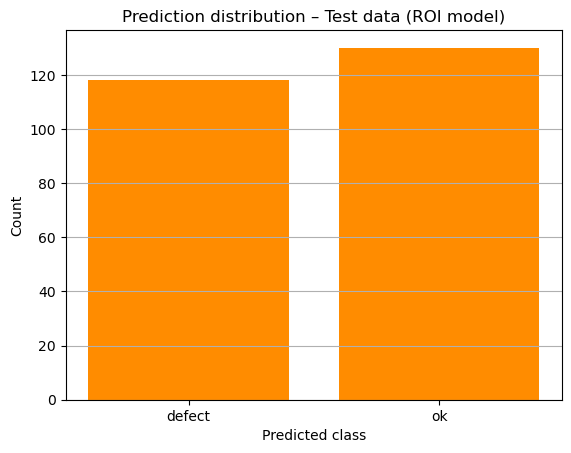

In [ ]:

# Load model
model_path = "syringe_model_roi_weighted.pkl"
model = joblib.load(model_path)

# Prediction on X_test
y_pred_test = model.predict(X_test)

# Show individual predictions
print("\n--- Individual predictions on test data (ROI model) ---")
for i, (true_label, predicted_label) in enumerate(zip(y_test, y_pred_test)):
    status = "correct" if true_label == predicted_label else "incorrect"
    print(f"Image {i+1}: TRUE = {true_label} | PREDICTED = {predicted_label} --> {status}")

# Summary of combinations
conf_matrix = Counter((t, p) for t, p in zip(y_test, y_pred_test))
print("\n--- Summary of prediction combinations ---")
for (true, pred), count in conf_matrix.items():
    print(f"{true} → {pred}: {count} times")

# Prediction distribution as bar chart
pred_counter = Counter(y_pred_test)
plt.bar(pred_counter.keys(), pred_counter.values(), color='darkorange')
plt.title("Prediction distribution – Test data (ROI model)")
plt.xlabel("Predicted class")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()
